<a href="https://colab.research.google.com/github/AchrafAsh/gnn-receptive-fields/blob/main/01_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## TODO

- fix MAD values


# Experimenting with our own Approach

## Setup environment

- load packages from google drive (to install once)
- configure working directory (to download datasets)



In [1]:
# setup colab environment
import os, sys
import os.path as osp
from google.colab import drive
drive.mount('/content/mnt')
nb_path = '/content/notebooks'
os.symlink('/content/mnt/My Drive/Colab Notebooks', nb_path)
sys.path.insert(0, nb_path)  # or append(nb_path)

Mounted at /content/mnt


In [2]:
%%capture
!wget https://raw.githubusercontent.com/AchrafAsh/gnn-receptive-fields/main/data.py
# !wget https://raw.githubusercontent.com/AchrafAsh/gnn-receptive-fields/main/utils.py

In [3]:
# import utility functions
from data import load_dataset
# from utils import mean_average_distance, mean_average_distance_gap

In [5]:
path = osp.join(os.getcwd(), 'data')
cora_dataset = load_dataset(path, 'Cora')
G = cora_dataset[0] # only graph of the dataset

Processing...
Done!


## The data (Cora): structure, processing


🎯 Filter edge_index to keep only the k-hop neighbors

In [6]:
G = cora_dataset[0] # Cora has only one graph
G.edge_index.shape  # [2, 10556] → 10_556 edges

torch.Size([2, 10556])

In [ ]:
node_a, node_b = G.edge_index[:,0]
node_i, node_j = node_a, node_b
i = 0
while node_i != node_b and node_j != node_a and i < G.edge_index.size(1):
    node_i, node_j = G.edge_index[:, i]
    i += 1
if i != G.edge_index.size(1):
    print("found it!")

found it!


That means that `edge_index` has both `a → b` and `b → a` (this is important for later processing)

In [ ]:
# edge_index is a sparse matrix of two rows, 
# each column is a pair of adjacent nodes 
# (not handy to find the neighbors of a given node)
i = 0
while i < 10:
    node_i, node_j = G.edge_index[:, i]
    if node_i != 0: break
    print(f"{node_i} → {node_j}")
    i += 1

0 → 633
0 → 1862
0 → 2582


### Compute k-hop neighborhoods

In [37]:
import copy
import torch
import time
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn

from torch_geometric.utils import to_dense_adj, dense_to_sparse

In [40]:
def get_neighbors(edge_index: torch.tensor) -> Dict[int, List[int]]:
    E = edge_index.size(1)
    neighbors = {}
    for i in range(E):
        node_i, node_j = edge_index[:, i]
        node_i, node_j = node_i.item(), node_j.item()
        try:
            neighbors[node_i] += [node_j]
        except:
            neighbors[node_i] = [node_j]
    return neighbors

In [41]:
def get_next_hop_neighbors(edge_index, direct_neighbors, neighborhood):
    """Returns the next hop of neighbors

    Args:
        edge_index (tensor): sparse adjacency matrix composed of edge indices
        direct_neighbors (dict): all the adjacent nodes
        neighborhood (dict): all the nodes in the (k-1)-hop neighborhood
    
    Returns:
        tensor: sparse matrix containing edge indices of the k-hop neighbors
        dict: direct neighbors
        dict: all the nodes in the k-hop neighborhood
    """
    neighborhood = copy.deepcopy(neighborhood)
    
    E = edge_index.size(1)
    new_edge_index = []
    for i in range(E):
        node_i, node_j = edge_index[:, i]
        node_i, node_j = node_i.item(), node_j.item()
        
        for node_k in direct_neighbors[node_j]:
            if node_k == node_i or node_k in neighborhood[node_i]: continue
            new_edge_index.append([node_i, node_k])
            neighborhood[node_i] += [node_k]
    
    if len(new_edge_index) > 0:
        new_edge_index = torch.transpose(torch.tensor(new_edge_index, dtype=edge_index.dtype), 1, 0)
    
    return new_edge_index, neighborhood

In [95]:
def get_all_hops(edge_index, k=1):
    """Returns all the k-hop neighbors and neighborhoods (all steps)

    Args:
        edge_index (tensor): sparse adjacency matrix composed of edge indices
        k (int): hop of neighbors to keep (e.g. k=1 is the regular adjacency matrix)
    
    Returns:
        List[tensor]: list of k sparse matrices containing edge indices for each k-hop
        List[dict]: list of k dictionaries (neighborhoods)
    """
    direct_neighbors = get_neighbors(edge_index)
    neighborhood = copy.deepcopy(direct_neighbors)
    
    all_edge_index, all_neighborhoods = [edge_index], [neighborhood]

    for i in range(1, k):
        next_edge_index, neighborhood = get_next_hop_neighbors(edge_index=all_edge_index[i-1], 
                                                               direct_neighbors=direct_neighbors,
                                                               neighborhood=all_neighborhoods[i-1])
        all_edge_index += [next_edge_index]
        all_neighborhoods += [neighborhood]

    return all_edge_index, all_neighborhoods

### Visualize neighborhood expansion

The diameter of the Cora dataset is 20, so in theory, the maximum number of neighbors should decrease all the way down to zero for `k=20`.
Let's check:

In [ ]:
nb_k_hop_neighbors = []
size_k_hop_neighborhood = []
k_grid = range(1, 20)

edge_index = G.edge_index
direct_neighbors = get_neighbors(G.edge_index)
neighborhood = copy.deepcopy(direct_neighbors)

# count neighbors
max_neighbors = len(max(direct_neighbors.values(), key=len))
min_neighbors = len(min(direct_neighbors.values(), key=len))
nb_k_hop_neighbors.append([min_neighbors, max_neighbors])

# count neighborhood
max_neighborhood = len(max(neighborhood.values(), key=len))
min_neighborhood = len(min(neighborhood.values(), key=len))
size_k_hop_neighborhood.append([min_neighborhood, max_neighborhood])

for k in k_grid:
    edge_index, neighborhood = get_next_hop_neighbors(edge_index=edge_index,
                                                      neighbors=direct_neighbors,
                                                      neighborhood=neighborhood)
    k_hop_neighbors = get_neighbors(edge_index)
    
    # count neighbors
    max_neighbors = len(max(k_hop_neighbors.values(), key=len))
    min_neighbors = len(min(k_hop_neighbors.values(), key=len))
    nb_k_hop_neighbors.append([min_neighbors, max_neighbors])

    # count neighborhood
    max_neighborhood = len(max(neighborhood.values(), key=len))
    min_neighborhood = len(min(neighborhood.values(), key=len))
    size_k_hop_neighborhood.append([min_neighborhood, max_neighborhood])

100%|██████████| 2/2 [00:00<00:00, 2181.13it/s]


IndexError: ignored

[Text(0.5, 1.0, 'Neighborhood expansion on Cora')]

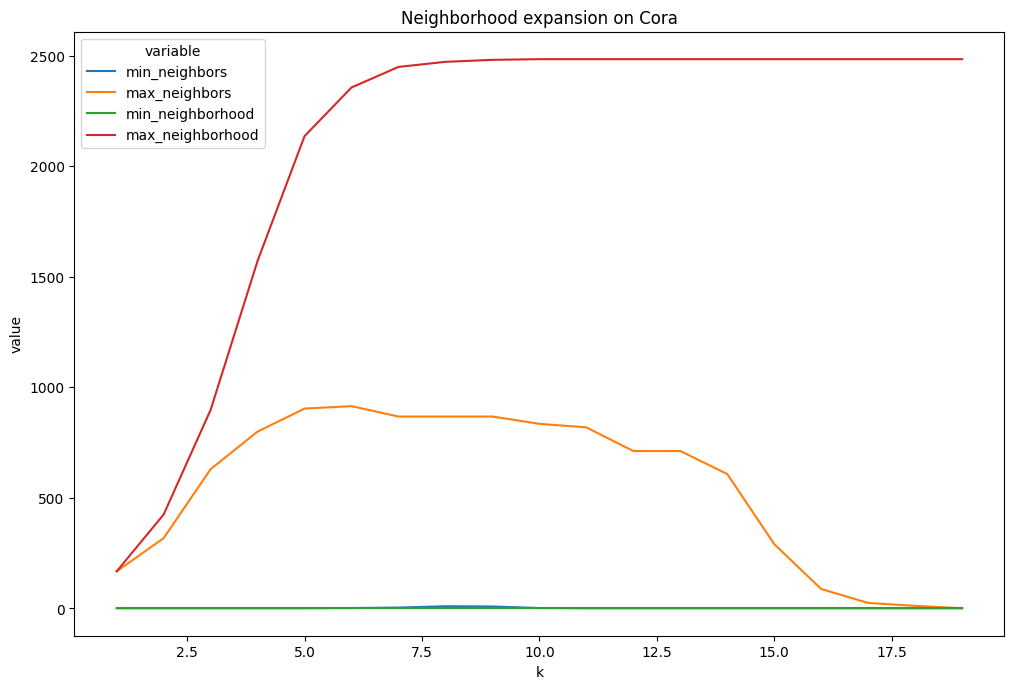

In [ ]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

# credit to: https://stackoverflow.com/a/55579762/11805354
data = pd.DataFrame({
    'k': range(1, 20),
    'min_neighbors': torch.tensor(nb_k_hop_neighbors)[:, 0],
    'max_neighbors': torch.tensor(nb_k_hop_neighbors)[:, 1],
    'min_neighborhood': torch.tensor(size_k_hop_neighborhood)[:, 0],
    'max_neighborhood': torch.tensor(size_k_hop_neighborhood)[:, 1],
})
sn.lineplot(x='k', y='value', hue='variable', data=pd.melt(data, ['k'])).set(title="Neighborhood expansion on Cora")

In [ ]:
data

,k,min_neighbors,max_neighbors,min_neighborhood,max_neighborhood
0,1,1,168,1,168
1,2,1,318,1,425
2,3,1,630,1,898
3,4,1,800,1,1572
4,5,1,904,1,2136
5,6,2,915,1,2356
6,7,4,868,1,2449
7,8,10,868,1,2472
8,9,9,868,1,2481
9,10,2,835,1,2484


Explanation:
- the min_neighbors can be bigger than min_neighborhood if two adjacent nodes are isolated, they will then be disregarded for the next hops, and thus not be considered for the min_neighborhood 💡

Result: the max_neighbors reach zero for the 20th hop which is what we expected ✅

## Measuring over-smoothing

In [147]:
def mean_average_distance(x, mask=None) -> float:
    """
    Computes cosine similarity between each pair of node representations

    Args:
        x (torch.tensor): node features [N, num_features]
        mask (torch.tensor): mask matrix composed of 0 and 1 only if the node pair (i,j) is the target one.
    
    :rtype: float
    """
    h = x.clone()

    D = 1 - torch.div(torch.matmul(h, torch.transpose(h, 0, 1)),
                      torch.matmul(torch.transpose(torch.norm(h, dim=1, keepdim=True), 0, 1), torch.norm(h, dim=1, keepdim=True)))
    if mask is not None:
        D = D * mask
    D_hat = torch.div( torch.sum(D, dim=1), torch.sum(D > 0, dim=1) )
    return torch.sum(D_hat) / torch.sum(D_hat > 0)

In [8]:
def mean_average_distance_gap(x, adj_matrix):
    '''
    Computes MADGap: MAD_remote - MAD_neighbors
    Args:
        x (torch.tensor): input feature matrix
        adj_matrix (torch.tensor): dense adjacency matrix
    '''
    # TODO: try to use the sparse adjacency matrix (like they did in MessagePassing)
    MAD_rem = mean_average_distance(x, mask=1-adj_matrix)
    MAD_neb = mean_average_distance(x, mask=adj_matrix)

    return MAD_rem - MAD_neb

## The model: our approach

In [34]:
import math
import random

import torch
import torch_geometric
import torch.nn.functional as F

from torch_geometric.nn import GCNConv, MessagePassing, Sequential
from torch_geometric.utils import degree, to_dense_adj

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
def xavier(tensor):
    """Initialize weight matrix with Xavier distribution

    Args:
        tensor (tensor): weigh matrix
    Return:
        tensor - weight matrix initialized
    """
    if tensor is not None:
        stdv = math.sqrt(6.0 / (tensor.size(-2) + tensor.size(-2)))
        tensor.data.uniform_(-stdv, stdv)

def zeros(tensor):
    """Initialize bias vector with all zeros

    Args:
        tensor (tensor): bias vector
    
    Return
        tensor - bias vector initialized with zeros
    """
    if tensor is not None:
        tensor.data.fill_(0)

### The HopGCNConv: our modified GCNConv layer

The only difference is that the Message part takes:
- the input features for neighbors
- the hidden state of the target node

In [28]:
class HopGCNConv(MessagePassing):
    def __init__(self, num_features:int, in_channels:int, out_channels:int, k:int):
        super(HopGCNConv, self).__init__(aggr='add')  # "Add" aggregation
        self.k = k
        self.lin_input = torch.nn.Linear(num_features, out_channels)
        self.lin_hidden = torch.nn.Linear(in_channels, out_channels)
        
        self.reset_parameters()
        
    def reset_parameters(self):
        xavier(self.lin_input.weight)
        zeros(self.lin_input.bias)
        
        xavier(self.lin_hidden.weight)
        zeros(self.lin_hidden.bias)

    def forward(self, x, h, edge_index):
        # x is the input features and has shape [N, num_features]
        # h is the hidden state and has shape [N, in_channels]
        # edge_index has shape [2, E] , E being the number of edges

        # step 1: linearly transform node feature matrices
        x = self.lin_input(x)
        h = self.lin_hidden(h)

        # step 3-5: start propagating messages
        return self.propagate(edge_index[self.k], x=x, h=h)

    def message(self, x_j, h_i, edge_index, size):
        # x_j is the input features of the neighbors and has shape [E, out_channels] (has already been multiplied by the weight matrix)

        # step 3: normalize node features
        row, col = edge_index
        deg = degree(row, size[0], dtype=x_j.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        out = norm.view(-1, 1) * x_j

        # add the hidden state of the target node
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[row]
        
        return out + norm.view(-1, 1) * h_i

    def update(self, aggr_out):
        # aggr_out has shape [N, out_channels]

        # step 5: return new node embeddings
        return aggr_out

In [113]:
# model should be as follows:
dropout=0.5
model = Sequential("x, edge_index",[
    (HopGCNConv(num_features=cora_dataset.num_features, in_channels=cora_dataset.num_features, out_channels=16, k=0), "x, x, edge_index -> h"),
    (torch.nn.ReLU(), "h -> h"),
    (torch.nn.Dropout(p=dropout), "h -> h"),

    (HopGCNConv(num_features=cora_dataset.num_features, in_channels=16, out_channels=16, k=1), "x, h, edge_index -> h"),
    (torch.nn.ReLU(), "h -> h"),
    (torch.nn.Dropout(p=dropout), "h -> h"),

    (HopGCNConv(num_features=cora_dataset.num_features, in_channels=16, out_channels=16, k=2), "x, h, edge_index -> h"),
    (torch.nn.ReLU(), "h -> h"),
    (torch.nn.Dropout(p=dropout), "h -> h"),
    
    (HopGCNConv(num_features=cora_dataset.num_features, in_channels=16, out_channels=16, k=3), "x, h, edge_index -> h"),
    (torch.nn.ReLU(), "h -> h"),
    (torch.nn.Dropout(p=dropout), "h -> h"),

    (HopGCNConv(num_features=cora_dataset.num_features, in_channels=16, out_channels=16, k=4), "x, h, edge_index -> h"),
    (torch.nn.ReLU(), "h -> h"),
    (torch.nn.Dropout(p=dropout), "h -> h"),
    
    (HopGCNConv(num_features=cora_dataset.num_features, in_channels=16, out_channels=16, k=5), "x, h, edge_index -> h"),
    (torch.nn.ReLU(), "h -> h"),
    (torch.nn.Dropout(p=dropout), "h -> h"),

    (HopGCNConv(num_features=cora_dataset.num_features, in_channels=16, out_channels=cora_dataset.num_classes, k=6), "x, h, edge_index -> h"),
    # (torch.nn.ReLU(), "h -> h"),
    # (torch.nn.Dropout(p=dropout), "h -> h"),

    (torch.nn.LogSoftmax(dim=1), "h -> h")
])

model.reset_parameters()
count_parameters(model)

The model has 172,125 parameters


### Build the model with nn.Module for more flexibility

In [154]:
for i in range(5, -1, -1): print(i)

5
4
3
2
1
0


In [155]:
class KHopNet(torch.nn.Module):
    def __init__(self, num_layers:int, hidden_dim:int, num_features:int, num_classes:int, dropout:float=0.5, invert:bool=False):
        super().__init__()
        self.conv_layers = self.create_layers(num_layers=num_layers, 
                                              num_features=num_features,
                                              num_classes=num_classes,
                                              hidden_dim=hidden_dim,
                                              dropout=dropout,
                                              invert=invert)
        
        self.log_softmax = torch.nn.LogSoftmax(dim=1)


    def create_layers(self, num_layers:int, num_features:int, num_classes:int, 
                      hidden_dim:int, dropout:float, invert:bool):
        layers = []
        if invert:
            k_grid = range(num_layers-1, -1, -1)
        else:
            k_grid = range(0, num_layers)

        # first layer
        layers += [
                (HopGCNConv(num_features=num_features, in_channels=num_features, out_channels=hidden_dim, k=k_grid[0]), "x, x, edge_index -> h"),
                (torch.nn.ReLU(), "h -> h"),
                (torch.nn.Dropout(p=dropout), "h -> h")
        ]

        for k in range(1, num_layers-1):
            layers += [
                (HopGCNConv(num_features=num_features, in_channels=hidden_dim, out_channels=hidden_dim, k=k_grid[k]), "x, h, edge_index -> h"),
                (torch.nn.ReLU(), "h -> h"),
                (torch.nn.Dropout(p=dropout), "h -> h")
            ]
        
        # last layer
        layers += [
            (HopGCNConv(num_features=num_features, in_channels=hidden_dim, out_channels=num_classes, k=k_grid[num_layers-1]), "x, h, edge_index -> h"),
            # (torch.nn.ReLU(), "h -> h"),
            # (torch.nn.Dropout(p=dropout), "h -> h") -> putting that prevent the model from learning
        ]
        return Sequential("x, edge_index", layers)


    def reset_parameters(self):
        self.conv_layers.reset_parameters()


    def forward(self, x, edge_index):
        h = self.conv_layers(x, edge_index)
        return h, self.log_softmax(h)

## Running Experiments

### Utility functions

In [44]:
from typing import Tuple, Dict, List
from tqdm import tqdm

In [17]:
# count model parameters
def count_parameters(model: torch.nn.Module):
    print(f"The model has {sum(p.numel() for p in model.parameters() if p.requires_grad):,} parameters")

In [121]:
def train(model: torch.nn.Module, optimizer: torch.optim.Optimizer,
          data: type(G), all_edge_index: list) -> Tuple[torch.tensor, float]:
    """Performs one training step
    """
    
    model.train()
    optimizer.zero_grad()

    hidden_state, out = model(data.x, all_edge_index)
    # out = model(data.x, all_edge_index)
    
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return hidden_state, loss
    # return loss

In [116]:
def evaluate(model: torch.nn.Module, data: type(G), all_edge_index: list) -> Dict[str, float]:
    """Evaluates the model
    """
    
    model.eval()

    with torch.no_grad():
        _, logits = model(data.x, all_edge_index)
        # logits = model(data.x, all_edge_index)
    
    outs = {}
    for key in ['train', 'val', 'test']:
        mask = data[f'{key}_mask']
        loss = F.nll_loss(logits[mask], data.y[mask]).item()
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()

        outs[f'{key}_loss'] = loss
        outs[f'{key}_acc'] = acc
    return outs

In [144]:
def run(data: type(G), model: torch.nn.Module,
        all_edge_index: List[torch.tensor],
        runs: int, epochs: int, lr: float,
        weight_decay: float,
        early_stopping: int = 0,
        initialize:bool=True) -> Tuple[List[float], List[float], List[float]]:
    """Wrapper function to run experiments

    Args:
        data (torch_geometric.data.data.Data): a graph
        model (torch.nn.Module): the model to train and test
        runs (int): number of experiments (training the model from scratch)
        epochs (int): number of epochs to train the model
        lr (float): learning rate
        weight_decay (float): for optimizer
        early_stopping (int):
        initialize (bool): whether to reset the parameters of the model
    
    Returns:
        list[float] - list of train loss
        list[float] - list of test accuracy
        list[float] - list of mean average distance
    """

    val_losses, accs, durations = [], [], []
    for _ in range(runs):
        data = data.to(device)
        model.to(device)
        if initialize:
            model.reset_parameters()
        
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, 
                                     weight_decay=weight_decay)

        if torch.cuda.is_available():
            torch.cuda.synchronize()
        
        t_start = time.perf_counter()

        best_val_loss = float('inf')
        val_loss_history, train_losses, test_accs, MADs = [], [], [], []

        for epoch in range(1, epochs+1):
            hidden_state, train_loss = train(model, optimizer, data, all_edge_index)
            # train_loss = train(model, optimizer, data, all_edge_index)

            MAD = mean_average_distance(x=hidden_state).item()
            eval_info = evaluate(model, data, all_edge_index)
            
            test_acc = eval_info['test_acc']
            val_loss_history.append(eval_info['val_loss'])
            train_losses.append(train_loss.item())
            test_accs.append(test_acc)
            MADs.append(MAD)
        
            # I don't understand what this is for...
            if eval_info['val_loss'] < best_val_loss:
                best_val_loss = eval_info['val_loss']
            
            if early_stopping > 0 and epoch > epochs // 2:
                tmp = torch.tensor(val_loss_history[-(early_stopping + 1):-1])
                if eval_info['val_loss'] > tmp.mean().item():
                    break
            
            if epoch % 10 == 0:
                print(f"Epoch: [{epoch} / {epochs}] | Loss: {train_loss} | Test accuracy: {test_acc} | MAD: {MAD}")
                # print(f"Epoch: [{epoch} / {epochs}] | Loss: {train_loss} | Test accuracy: {test_acc}")

        if torch.cuda.is_available():
            torch.cuda.synchronize()

        t_end = time.perf_counter()

        val_losses.append(best_val_loss)
        accs.append(test_acc)
        durations.append(t_end - t_start)

    loss, acc, duration = torch.tensor(val_losses), torch.tensor(accs), torch.tensor(durations)

    print(f"Val Loss: {loss.mean().item():.4f}, Test Accuracy: {acc.mean().item():.3f} ± {acc.std().item():.3f}, Duration: {duration.mean().item():.3f}")
    return train_losses, test_accs, MADs

In [169]:
def plot_results(train_losses: List[float], test_accs: List[float], mads: List[float]):
    # credits to: https://stackoverflow.com/a/43131357/11805354
    n = len(train_losses)

    data = pd.DataFrame({
        'epoch': range(1, n+1),
        'train_loss': train_losses,
        'test_acc': test_accs,
        'MAD': mads
    })

    plt.rcParams['figure.figsize'] = [18, 5]
    plt.rcParams['figure.dpi'] = 100

    fig, ax =plt.subplots(1,4)

    sn.lineplot(x=range(1, n+1), y=train_losses, ax=ax[0]).set(xlabel="epochs", ylabel="loss", title="Train Loss")
    sn.lineplot(x=range(1, n+1), y=test_accs, ax=ax[1]).set(xlabel="epochs", ylabel="accuracy", title="Test Accuracy")
    sn.lineplot(x=range(1, n+1), y=mads, ax=ax[2]).set(xlabel="epochs", ylabel="MAD", title="Test MAD")
    
    sn.lineplot(x='epoch', y='value', hue='variable', data=pd.melt(data, ['epoch']), ax=ax[3]).set(title="Experiment results")

    fig.show()

In [ ]:
class Experiment:
    def __init__(self, layers:int, hidden_dim: int, epochs:int, lr:float, weight_decay:float, early_stopping: int):
        self.layers = layers
        self.hidden_dim = hidden_dim
        self.epochs = epochs
        self.lr = lr
        self.weight_decay = weight_decay
        self.early_stopping = early_stopping

        self.model = self.build_model()

    def build_model(self):
        pass

    def train(self):
        pass

    def evaluate():
        pass

### Experiments

In [159]:
all_edge_index, _ = get_all_hops(G.edge_index, k=8)

In [197]:
NUM_LAYERS=6
HIDDEN_DIM=64
NUM_FEATURES=cora_dataset.num_features
NUM_CLASSES=cora_dataset.num_classes
EPOCHS=200
LR=0.01
WEIGHT_DECAY=5e-4
EARLY_STOPPING=0
RUNS=1

In [198]:
model = KHopNet(num_layers=NUM_LAYERS, hidden_dim=HIDDEN_DIM, 
                num_features=NUM_FEATURES,
                num_classes=NUM_CLASSES,
                invert=True)

count_parameters(model)

The model has 577,789 parameters


In [199]:
train_loss, test_acc, mads = run(G, model, 
                                 all_edge_index=all_edge_index,
                                 runs=RUNS, 
                                 epochs=EPOCHS, lr=LR,
                                 weight_decay=WEIGHT_DECAY,
                                 early_stopping=EARLY_STOPPING,
                                 initialize=False)

Epoch: [10 / 200] | Loss: 21.361886978149414 | Test accuracy: 0.338 | MAD: 0.9999998211860657
Epoch: [20 / 200] | Loss: 43.03731155395508 | Test accuracy: 0.519 | MAD: 0.9999996423721313
Epoch: [30 / 200] | Loss: 6.599836826324463 | Test accuracy: 0.591 | MAD: 0.9999996423721313
Epoch: [40 / 200] | Loss: 8.279692649841309 | Test accuracy: 0.639 | MAD: 0.9999998211860657
Epoch: [50 / 200] | Loss: 0.6602229475975037 | Test accuracy: 0.642 | MAD: 0.9999998807907104
Epoch: [60 / 200] | Loss: 4.130027770996094 | Test accuracy: 0.633 | MAD: 0.9999996423721313
Epoch: [70 / 200] | Loss: 8.31960678100586 | Test accuracy: 0.637 | MAD: 0.9999995231628418
Epoch: [80 / 200] | Loss: 0.9223966598510742 | Test accuracy: 0.66 | MAD: 0.9999995231628418
Epoch: [90 / 200] | Loss: 0.4245145916938782 | Test accuracy: 0.664 | MAD: 0.9999997019767761
Epoch: [100 / 200] | Loss: 0.10039259493350983 | Test accuracy: 0.653 | MAD: 0.9999998211860657
Epoch: [110 / 200] | Loss: 0.09520626813173294 | Test accuracy: 0

In [200]:
evaluate(model, G, all_edge_index)

{'test_acc': 0.688,
 'test_loss': 2.1800098419189453,
 'train_acc': 1.0,
 'train_loss': 0.06655801832675934,
 'val_acc': 0.692,
 'val_loss': 1.1512253284454346}

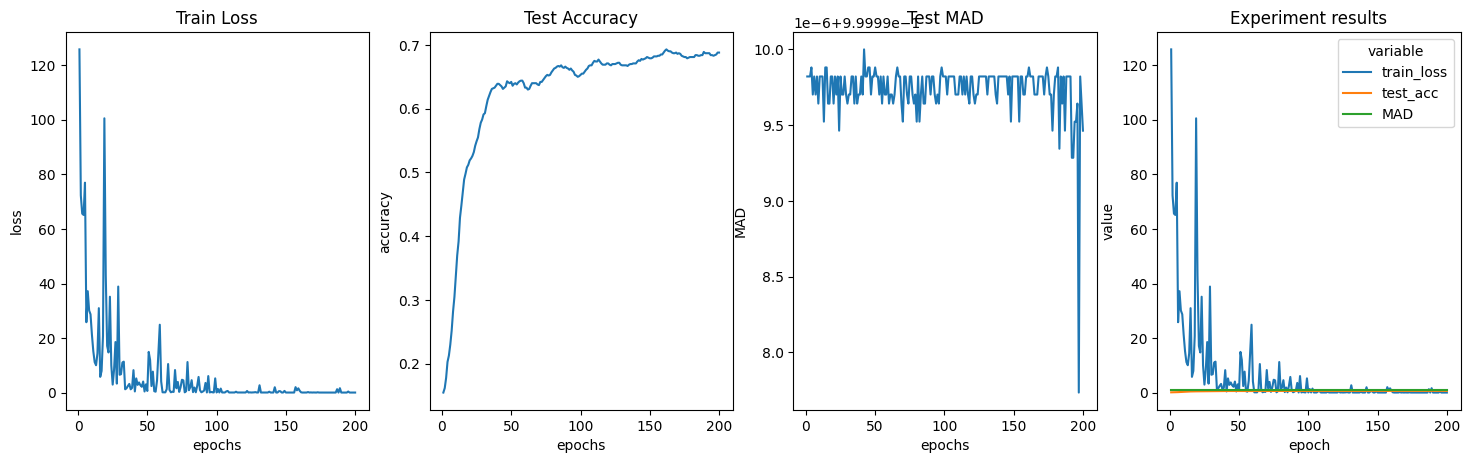

In [201]:
plot_results(train_loss, test_acc, mads)